# BERT MLM 训练效果分析
本 notebook 包含对 UNK 比例、Mask 覆盖率、Loss 分布的分析。

In [6]:
from transformers import PreTrainedTokenizerFast
from datasets import load_from_disk,DatasetDict

tokenizer = PreTrainedTokenizerFast.from_pretrained("dataset/tokenizer/wp_tokenizer_31000")
tokenized_dataset = load_from_disk("dataset/huggingface/standard_hex_tokenized_31000")
# 拆分验证集和测试集
split_dataset = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
valid_test_split = split_dataset["test"].train_test_split(test_size=0.5, seed=42)
tokenized_dataset = DatasetDict(
    {
        "train": split_dataset["train"],
        "valid": valid_test_split["train"],
        "test": valid_test_split["test"],
    }
)

In [7]:
# 计算 UNK 占比
def compute_unk_ratio(example):
    unk_id = tokenizer.unk_token_id
    input_ids = example["input_ids"]
    total = len(input_ids)
    unk_count = sum(1 for x in input_ids if x == unk_id)
    return {"unk_ratio": unk_count / total if total > 0 else 0}

unk_stats = tokenized_dataset["valid"].map(compute_unk_ratio)

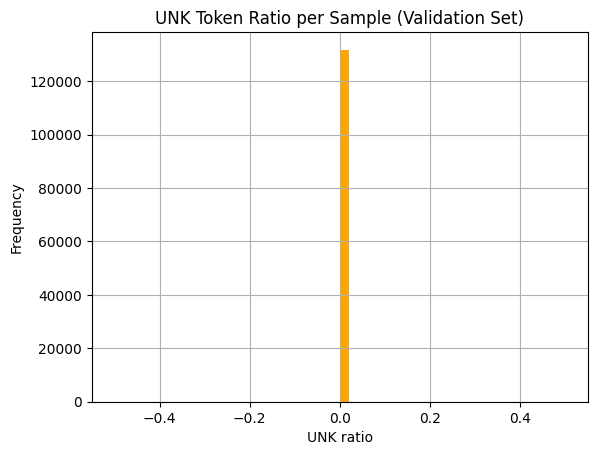

In [8]:
# 可视化 UNK 比例
import matplotlib.pyplot as plt

ratios = [ex["unk_ratio"] for ex in unk_stats]
plt.hist(ratios, bins=50, color="orange")
plt.title("UNK Token Ratio per Sample (Validation Set)")
plt.xlabel("UNK ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Map:   0%|          | 0/131799 [00:00<?, ? examples/s]

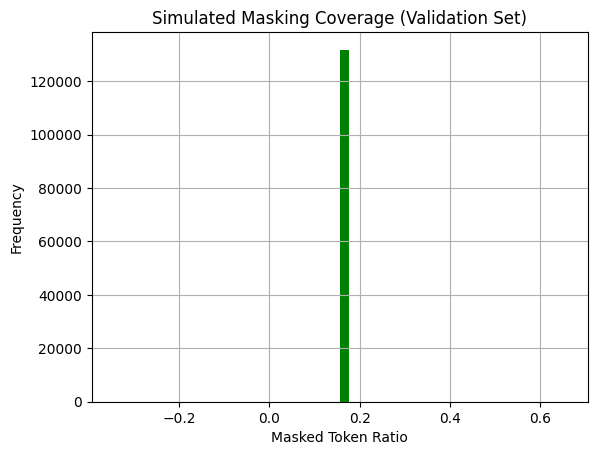

In [9]:
# 模拟 MLM 的 mask 覆盖率
import numpy as np

def compute_mask_effectiveness(example):
    input_ids = example["input_ids"]
    input_len = len(input_ids)
    mlm_probability = 0.15
    np.random.seed(42)
    mask_flags = np.random.rand(input_len) < mlm_probability
    effective_mask_count = np.sum(mask_flags)
    return {
        "masked_ratio": effective_mask_count / input_len if input_len > 0 else 0
    }

mask_stats = tokenized_dataset["valid"].map(compute_mask_effectiveness)
masked_ratios = [x["masked_ratio"] for x in mask_stats]

plt.hist(masked_ratios, bins=50, color='green')
plt.title("Simulated Masking Coverage (Validation Set)")
plt.xlabel("Masked Token Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

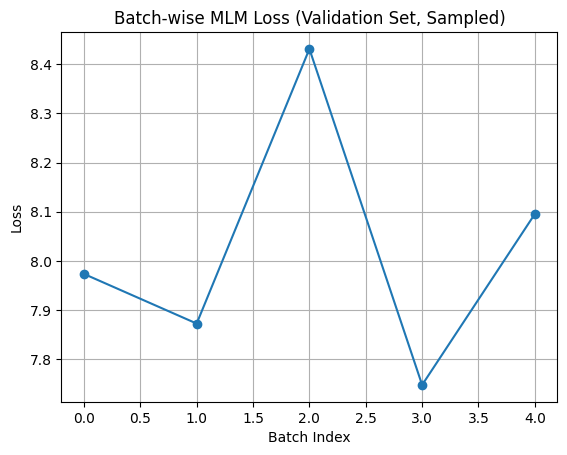

In [12]:
# Loss 分布分析
from transformers import BertForMaskedLM
import torch

model = BertForMaskedLM.from_pretrained("output/checkpoint-21968")

def get_loss_distribution(dataset, model, tokenizer, batch_size=32):
    model.eval()
    losses = []
    mask_token_id = tokenizer.mask_token_id

    for i in range(0, len(dataset), batch_size):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        input_ids = torch.tensor(batch["input_ids"])
        attention_mask = torch.tensor(batch["attention_mask"])
        labels = input_ids.clone()
        rand = torch.rand(input_ids.shape)
        mask_arr = (rand < 0.15) * (input_ids != tokenizer.pad_token_id) * (input_ids != tokenizer.cls_token_id) * (input_ids != tokenizer.sep_token_id)
        selection = []

        for b in range(input_ids.shape[0]):
            selection.append(torch.flatten(mask_arr[b].nonzero()).tolist())

        for b in range(input_ids.shape[0]):
            input_ids[b, selection[b]] = mask_token_id
        labels[~mask_arr] = -100

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            losses.append(loss.item())

        if i > 100:
            break
    return losses

losses = get_loss_distribution(tokenized_dataset["valid"], model, tokenizer)
plt.plot(losses, marker='o')
plt.title("Batch-wise MLM Loss (Validation Set, Sampled)")
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.grid(True)
plt.show()